In [42]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.dates as md

### Read in the data

In [43]:
fs = glob.glob('data/*/*')
fields = ['text', 'lang']
metrics = [f'{m}_count' 
           for m in ['like','quote','reply','retweet']]
processed_tws = []
for f in fs:
    tws = json.load(open(f))['data']
    for i in range(len(tws)):
        item = {k: tws[i][k] for k in fields}
        item.update({k: tws[i]['public_metrics'][k] for k in metrics})
        item.update({'created_at': tws[i]['created_at'][:10]})
        tws[i] = item
    processed_tws += tws

In [44]:
df = pd.DataFrame(processed_tws)
df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True)

### Tweet volume

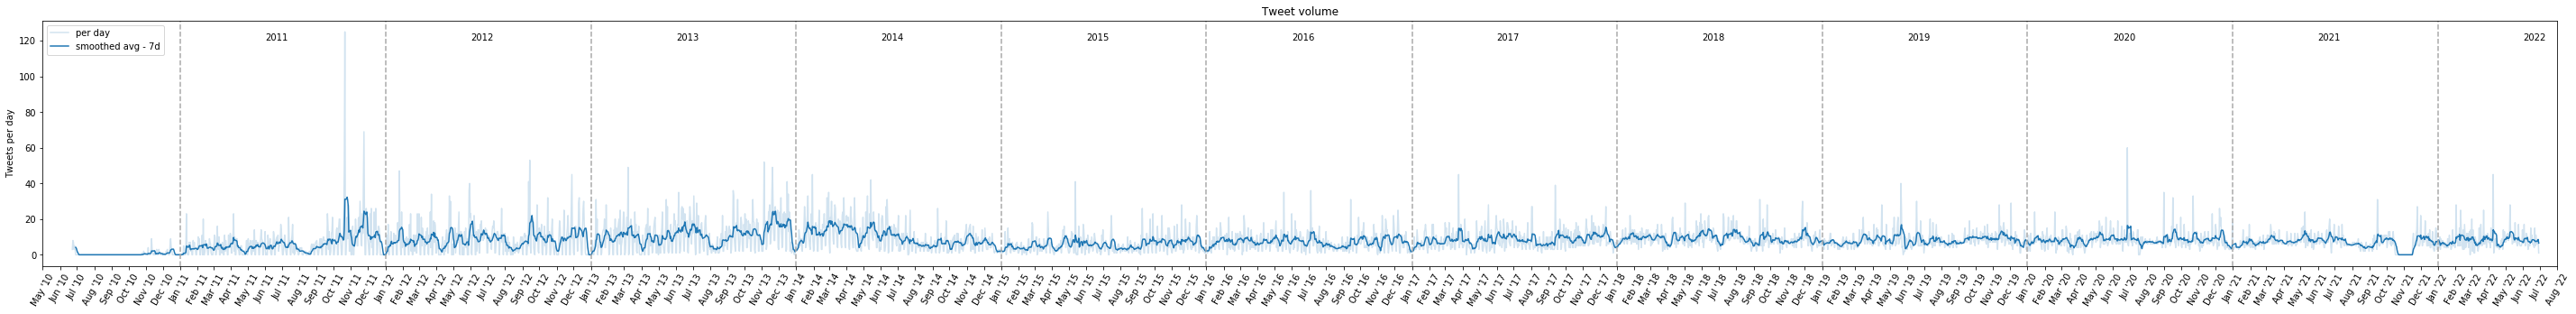

In [45]:
freq_dict = {'D': 'day', 'W': 'week', 'M': 'month'}
figsizes = {'D': (50,5), 'W': (50,5), 'M': (30, 5)}
formats = {'D': '%Y-%m-%d', 'W': '%Y-%m-%d', 'M': '%Y-%m'}
top_dict = {}
for freq in ['D']:
    fig, ax = plt.subplots(figsize=figsizes[freq])
    grouped = df.groupby(pd.Grouper(key='created_at', axis=0, freq=freq)).count().reset_index()
    top_dict[freq_dict[freq]] = grouped.sort_values(by='text', ascending=False).head(n=5)[['created_at', 'text']].to_records(index=False)
    grouped['smoothed'] = grouped['text'].rolling(7).mean()
    # Plot 
    sns.lineplot(data=grouped, x='created_at', y='text', 
                 alpha=.2, 
                 label='per day')
    sns.lineplot(data=grouped, x='created_at', y='smoothed', 
                 label='smoothed avg - 7d', 
                 color=sns.color_palette()[0])
    plt.ylabel(f'Tweets per {freq_dict[freq]}')
    plt.xlabel('')
    plt.title('Tweet volume')
    plt.xticks(rotation=60)
    # Make year boundaries
    for d in grouped.created_at.dt.year.unique()[1:]:
        plt.axvline(x=np.datetime64(f'{d}-01-01'), color='darkgrey', linestyle='--')
        plt.annotate(s=d, xy=(np.datetime64(f'{d}-06-01'),120), color='black')
    ax.xaxis.set_major_locator(md.MonthLocator())
    ax.xaxis.set_major_formatter(md.DateFormatter('%b \'%y'))
    plt.xlim(np.datetime64('2010-05-01'),np.datetime64('2022-08-01'))
    plt.savefig('figures/tweet_volume.pdf')
    plt.show()

In [46]:
print(df[df.created_at == np.datetime64(top_dict['day'][1][0])].text.tolist())
print(top_dict['day'][1][0])

['Air transport: #EC requests Austria, Germany, Italy and Luxembourg to comply with rules on airport charges  http://t.co/sVQ7iwfQ', 'Maritime safety:#EC requests #Italy to comply with new safety rules for passenger ships http://t.co/hMqNwrO7', 'Rail: #EC refers #Germany to Court of Justice over railway safety http://t.co/0Nfo9eAp', '#EC asks the #United Kingdom to pay due amounts of customs duties to #EU budget  http://t.co/qsjObEPR', 'Free movement of goods: #EC requests #Greece to facilitate the selling of "bake off" products  http://t.co/qH6GSk8m', 'Free movement of goods: #EC requests #Netherlands to comply with EU rules on firearms  http://t.co/3KCimGLY', "Working time: #EC requests #Belgium to end compulsory postponement of workers' annual leave http://t.co/U9GlQkPC", 'Free movement of workers: #EC requests #Italy to end discrimination in recruiting university professors  http://t.co/PFJGDfLI', 'Social Security: #EC requests #Spain to end refusal of European Health Insurance Car

Some of the peaks with highest volumes are related to live tweeting of #EUMFF negotiations, automated posting re: to activity on other websites (Storify), and other. 
Worth keeping in mind that tweet volume can be a major confounder with this data.

### Additional preprocessing
- flag retweets and tweets starting with mentions;
- strip links;
- not removing emojis, hashtags and mentions, for now - but could remove depending on which model we end up using.

In [8]:
df['is_retweet'] = np.where(df['text'].str.startswith('RT'), 1, 0)
df['is_mention'] = np.where(df['text'].str.startswith('@'), 1, 0)
df['text'] = df['text'].str.replace(r'http.*', '', regex=True)
df = df[df['text'].str.len() > 0]
df.to_csv('processed/all_tweets.tsv', sep='\t')

Breakdown of number of tweets per language

In [9]:
df.groupby('lang')['text'].count().reset_index().sort_values(by='text', ascending=False).rename({'text': 'count'}, axis=1)

,lang,count
7,en,32446
12,fr,828
5,de,207
8,es,155
29,und,122
17,it,81
24,ro,69
28,uk,47
22,pl,45
20,nl,37


Removing tweets not in English, it's mostly translations of English tweets

In [ ]:
df = df[df['lang']=='en']

### Train-test splits
Let's leave out a small dataset for pretraining of our language models. We pick a random set of tweets (if that does not show good results, we could consider balanced sampling over time).

In [10]:
import random
random.seed(42)

train_size = 3000
val_size = 500

train_test = ['train'] * train_size + ['val'] * val_size + ['test'] * (df.shape[0] - train_size - val_size)
random.shuffle(train_test)
df['pretraining_splits'] = train_test

Great, now let's fine tune some language models on these tweets for better performance. 

In [ ]:
from pretrain import Pretrainer
models = ['distilbert-base-uncased', 
          'distilroberta-base',
          'all-mpnet-base-v2', 
          'all-distilroberta-v1',
          'all-MiniLM-L12-v2']
for m in models:
    trainer = Pretrainer('distilbert-base-uncased', df[df['lang']=='en'])
    trainer.compile()
    trainer.fit()
    trainer.save()

### Topic modeling
Let's move on to modeling the topic of the tweets. We'll try to compare different modeling strategies, and both pretrained and fine-tuned models.
Then, we'll try to get an idea of what the evolution of topics has been over time. 

In [12]:
from octis.models.CTM import CTM
from octis.dataset.dataset import Dataset
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Categorical, Integer
from octis.evaluation_metrics.coherence_metrics import Coherence

/Users/rr48396/opt/anaconda3/lib/python3.7/site-packages/huggingface_hub/snapshot_download.py:11: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  FutureWarning,


TODO:
- Fine-tune
- Topic modeling
- Most liked / retweeted content, as a function of topic
- Annotate emotions and also look at topic & engagement as a function of emotions